In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

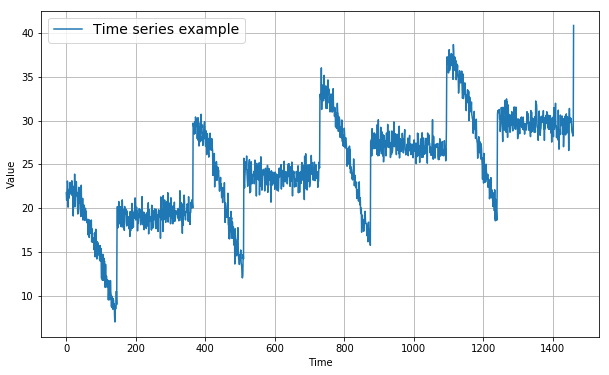

In [3]:
# Define the time series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * (np.sqrt(time))

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# The time series
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time,0.5) + white_noise(time, noise_level=1, seed=0) + seasonality(time, period=365, amplitude=10, phase=0)
# Plot
plt.figure(figsize=(10, 6))
plot_series(time, series, label='Time series example')
plt.show()

In [4]:
# Train and validation split
x_train = time[:1000]
y_train = series[:1000]
x_val = time[1000:]
y_val = series[1000:]
# Train and val sets
window_size = 30
train_set = window_dataset(y_train, window_size=30) 
val_set = window_dataset(y_val, window_size=30)

In [5]:
# Model fitting: linear model
model =  tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[window_size])
])
model.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=300, validation_data=val_set,callbacks=[early_stopping])

Epoch 1/300
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
31/31 [==============================] - 2s 60ms/step - loss: 38.1398 - mae: 38.8614 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/300
31/31 [==============================] - 1s 22ms/step - loss: 20.0227 - mae: 18.0546 - val_loss: 8.8360 - val_mae: 9.3648
Epoch 3/300
31/31 [==============================] - 1s 23ms/step - loss: 2.8438 - mae: 2.9464 - val_loss: 1.2727 - val_mae: 1.7011
Epoch 4/300
31/31 [==============================] - 1s 20ms/step - loss: 1.3810 - mae: 1.7761 - val_loss: 1.2871 - val_mae: 1.6814
Epoch 5/300
31/31 [==============================] - 1s 20ms/step - loss: 1.3050 - mae: 1.7443 - val_loss: 1.2595 - val_mae: 1.6964
Epoch 6/300
31/31 [==============================] - 1s 21ms/step - loss: 1.3215 - mae: 1.7401 - val_loss: 1.2410 - val_mae: 1.6837
Epoch 7/300
31/31 [==============================] - 1s 18ms/step - loss: 1.3426 - mae: 1.7425 - val_l

In [6]:
# Predictions function
def model_forecasts(model, series, window_size):
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda window: window.batch(window_size))
    data = data.batch(32).prefetch(1)
    return model.predict(data)

3.020062


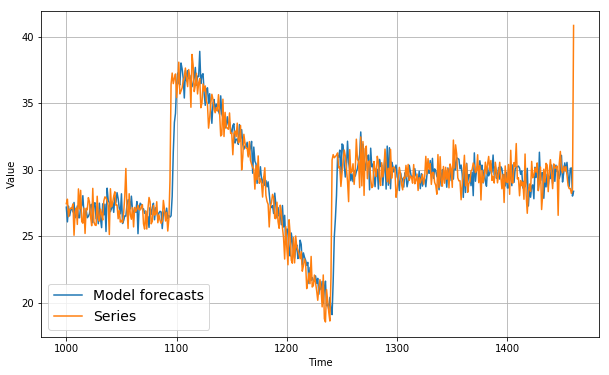

In [7]:
forecasts = model_forecasts(model, series[1000-window_size:-1], window_size=window_size)[:,0]
plt.figure(figsize=(18,10))
plot_series(x_val, forecasts, label='Model forecasts')
plot_series(x_val, y_val, label='Series')
print(tf.keras.metrics.mean_squared_error(y_val, forecasts).numpy())

# Denser model

In [14]:
# Model fitting: linear model
model2 =  tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=1)
])
model2.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model2.fit(train_set, epochs=300, validation_data=val_set,callbacks=[early_stopping])

Epoch 1/300
31/31 [==============================] - 1s 46ms/step - loss: 10.5664 - mae: 11.2070 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/300
31/31 [==============================] - 0s 16ms/step - loss: 1.5752 - mae: 1.9231 - val_loss: 1.4726 - val_mae: 1.9230
Epoch 3/300
31/31 [==============================] - 0s 15ms/step - loss: 1.1928 - mae: 1.5392 - val_loss: 1.0697 - val_mae: 1.4690
Epoch 4/300
31/31 [==============================] - 0s 15ms/step - loss: 1.0658 - mae: 1.4567 - val_loss: 0.9817 - val_mae: 1.3795
Epoch 5/300
31/31 [==============================] - 1s 16ms/step - loss: 1.0288 - mae: 1.4255 - val_loss: 0.9572 - val_mae: 1.3720
Epoch 6/300
31/31 [==============================] - 0s 16ms/step - loss: 1.0201 - mae: 1.4226 - val_loss: 0.9202 - val_mae: 1.3179
Epoch 7/300
31/31 [==============================] - 0s 15ms/step - loss: 0.9689 - mae: 1.3601 - val_loss: 0.9254 - val_mae: 1.2959
Epoch 8/300
31/31 [==============================] - 0s 16ms/step 

2.81969


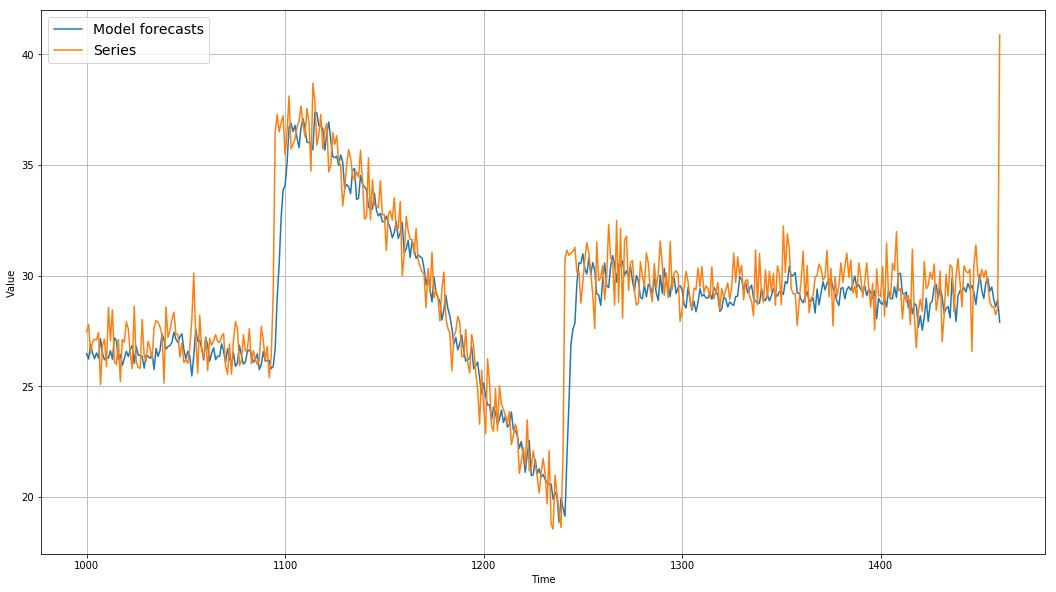

In [15]:
forecasts2 = model_forecasts(model2, series[1000-window_size:-1], window_size=window_size)[:,0]
plt.figure(figsize=(18,10))
plot_series(x_val, forecasts2, label='Model forecasts')
plot_series(x_val, y_val, label='Series')
print(tf.keras.metrics.mean_squared_error(y_val, forecasts2).numpy())

# Differencing and dense model

1096


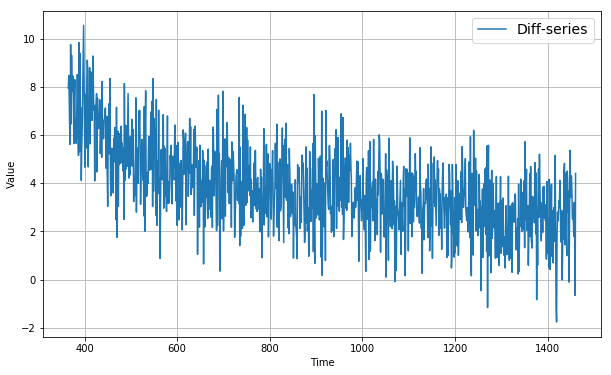

In [27]:
# Differencing
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series, label='Diff-series')
print(len(diff_series))

In [36]:
# Train and validation split for diff data
diff_y_train = diff_series[:1000-365]
diff_y_val = diff_series[1000-365:]
# Train and val sets
window_size = 30
diff_train_set = window_dataset(diff_y_train, window_size=30) 
diff_val_set = window_dataset(diff_y_val, window_size=30)

In [47]:
# Train model on differenced data
model3 =  tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(units=10, activation="relu"),
    tf.keras.layers.Dense(units=1)
])
model3.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=15)
model3.fit(diff_train_set, epochs=300, validation_data=diff_val_set,callbacks=[early_stopping])

Epoch 1/300
19/19 [==============================] - 1s 75ms/step - loss: 6.6385 - mae: 7.1520 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/300
19/19 [==============================] - 0s 21ms/step - loss: 1.9255 - mae: 2.1207 - val_loss: 0.8634 - val_mae: 1.2703
Epoch 3/300
19/19 [==============================] - 0s 21ms/step - loss: 0.9620 - mae: 1.3915 - val_loss: 0.8416 - val_mae: 1.2514
Epoch 4/300
19/19 [==============================] - 0s 23ms/step - loss: 0.8963 - mae: 1.3134 - val_loss: 0.8706 - val_mae: 1.2712
Epoch 5/300
19/19 [==============================] - 0s 20ms/step - loss: 0.8569 - mae: 1.2859 - val_loss: 0.8383 - val_mae: 1.2456
Epoch 6/300
19/19 [==============================] - 0s 21ms/step - loss: 0.8864 - mae: 1.2765 - val_loss: 0.8382 - val_mae: 1.2392
Epoch 7/300
19/19 [==============================] - 0s 22ms/step - loss: 0.8328 - mae: 1.2657 - val_loss: 0.8275 - val_mae: 1.2306
Epoch 8/300
19/19 [==============================] - 0s 21ms/step - 

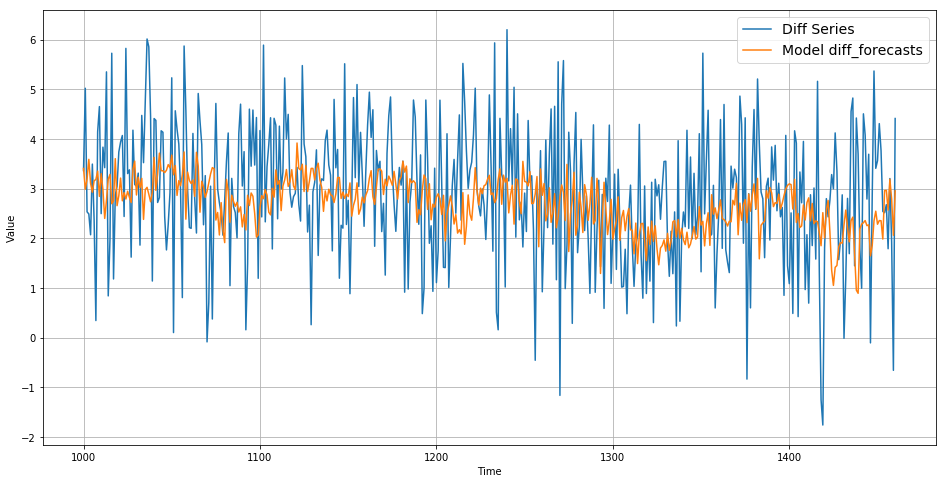

In [48]:
forecasts_diff = model_forecasts(model3, diff_series[1000-365-window_size:-1], window_size=window_size)[:,0]
plt.figure(figsize=(16,8))
plot_series(x_val, diff_y_val, label='Diff Series')
plot_series(x_val, forecasts_diff, label='Model diff_forecasts')

1.9731649227595454


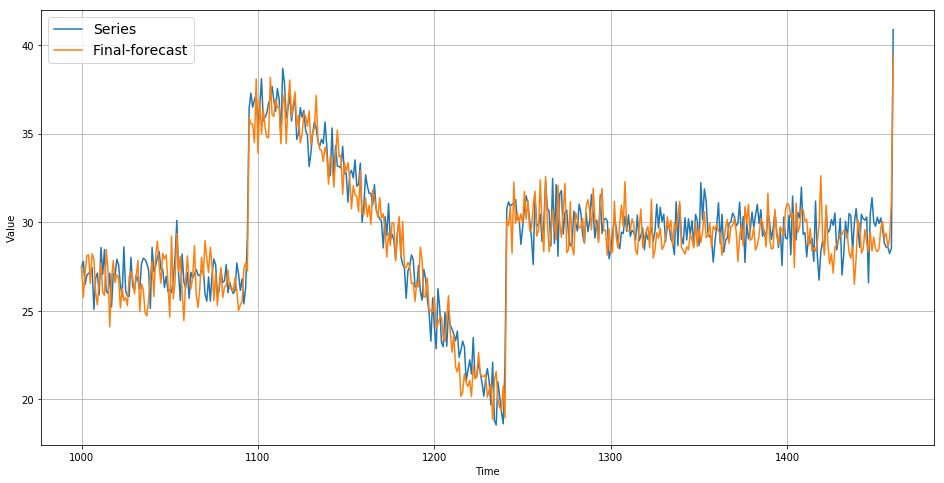

In [49]:
# De-differencing
final_forecast3 = forecasts_diff + series[1000-365:1000-365+len(y_val)]
plt.figure(figsize=(16, 8))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, final_forecast3, label="Final-forecast")
print(tf.keras.metrics.mean_squared_error(y_val, final_forecast3).numpy())